# **Import Libraries**

In [0]:
# import libraries
import datetime as dt

import matplotlib.pyplot            as plt
from   matplotlib                   import style
%matplotlib inline

import numpy                        as np

import pandas                       as pd
from   pandas.plotting                import scatter_matrix
import pandas_datareader.data       as web

import plotly.plotly                as py
import plotly.tools                 as tls

import seaborn                       as sns; sns.set(color_codes=True)

from   sklearn.linear_model          import LinearRegression
from   sklearn.metrics               import mean_squared_error as MSE
from   sklearn.metrics               import mean_squared_log_error as MSLE
from   sklearn.model_selection       import train_test_split as split
from   sklearn.preprocessing         import LabelEncoder, OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

Good explenation on regression, but using statmodels instead of sklearn

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

# **Get Data**

In [0]:
# # Get Data
# # path of data
# path = "c:\\xxx\\yyy\\name.csv"
all_data = pd.read_csv('BeerConsumption_Original.csv', delimiter = ',')

In [39]:
# Choose relevant population
df = all_data.copy()       # create a copy of the data
df.index                   # index the data
df.head()

,date,temp_min,temp_med,temp_max,precipitation,weekend,consumption
0,01-01-15,23.9,27.30,32.5,0.0,0,25461
1,02-01-15,24.5,27.02,33.5,0.0,0,28972
2,03-01-15,22.4,24.82,29.9,0.0,1,30814
3,04-01-15,21.5,23.98,28.6,1.2,1,29799
4,05-01-15,21.0,23.82,28.3,0.0,0,28900


# **Prepare Data and EDA**

In [0]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)     # transform column 'date' to date field
df['consumption'] = df['consumption'].astype(int)          # transform column 'consumption' to int field



In [41]:
df.info()            # provide information of the df columns
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
date             365 non-null datetime64[ns]
temp_min         365 non-null float64
temp_med         365 non-null float64
temp_max         365 non-null float64
precipitation    365 non-null float64
weekend          365 non-null int64
consumption      365 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 20.0 KB


,temp_min,temp_med,temp_max,precipitation,weekend,consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,17.461370,21.226356,26.611507,5.196712,0.284932,25401.367123
std,2.826185,3.180108,4.317366,12.417844,0.452001,4399.142703
min,10.600000,12.900000,14.500000,0.000000,0.000000,14343.000000
25%,15.300000,19.020000,23.800000,0.000000,0.000000,22008.000000
50%,17.900000,21.380000,26.900000,0.000000,0.000000,24867.000000
75%,19.600000,23.280000,29.400000,3.200000,1.000000,28631.000000
max,24.500000,28.860000,36.500000,94.800000,1.000000,37937.000000


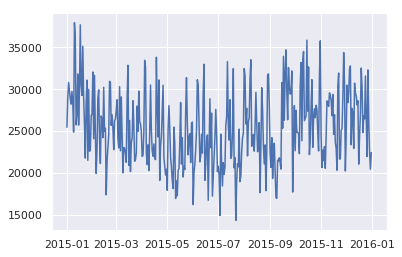

In [42]:
# plot original data over time
fig = plt.figure()
ax = plt.axes()

x = df['date']
y = df['consumption']
ax.plot(x, y);

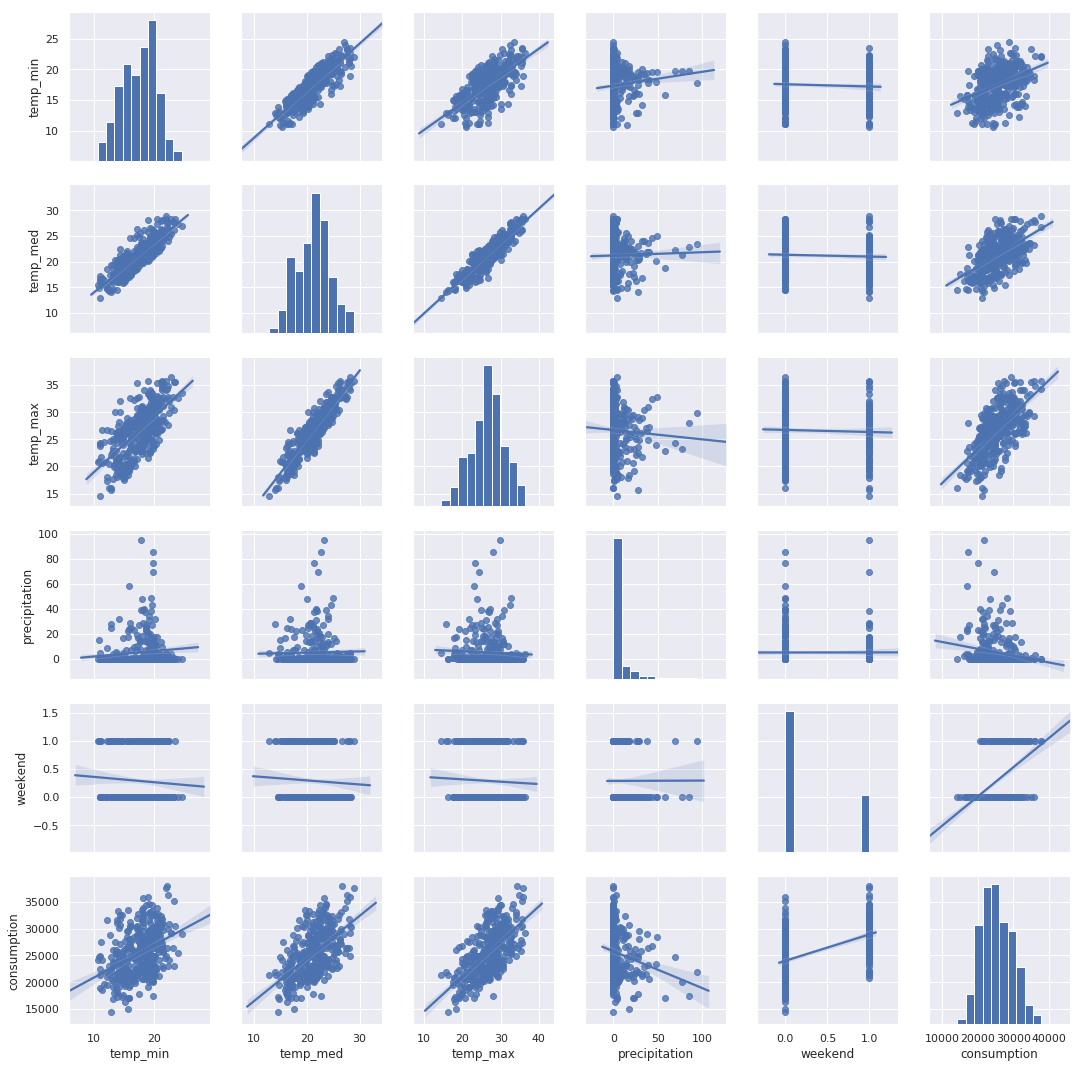

In [43]:
# sns.pairplot(df, hue = 'weekend', kind = 'reg')       # plot correlations between features of original data
sns.pairplot(df, kind = 'reg')       # plot correlations between features of original data

### **Initial Analysis and Data Augmentation**
1. **Drop 'temp_min' and 'temp_med'**. There seems to be multi-colinearity between the temperature fields ('temp_min', 'temp_med', 'temp_max'). Keeping 'temp_max' makes more sense re beer consumption. Also, 'temp_max' has a more symmetrical distribution making it more attractive for analysis.
2. On average, there seems to be more beer consumption on the weekend than on weekdays.
3. **Add two fields: 'day' and 'month'**. Looking at consumption over time (by days over the year) is messy. We need to aggregate to day level and month level.
4. **Add 2 fields: precip_lte10 precip_gt10**: We see a slight trend of decreasing beer consumption as precipitation increases. 

In [0]:
df1 = df.drop(['temp_min', 'temp_med'], axis = 1)         # dropping 'temp_min' and 'temp_med' columns

In [0]:
# converting dates to days of week

# creating a temp copy of the date field for day and month conversion
df1['date_temp'] = pd.to_datetime(df1['date'])

df1['day_of_week'] = df1['date_temp'].dt.day_name()
df1['day_of_week'] = df1['day_of_week'].replace({'Sunday': 1, 'Monday': 2, 'Tuesday':3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7})

In [0]:
# converting dates to months
df1['date_temp'] = pd.to_datetime(df1['date'])
df1['month'] = df1['date_temp'].dt.month_name()
df1['month'] = df1['month'].replace({'January':1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})

In [0]:
# converting dates to days of year
df1['day_of_year'] = df1['date'].dt.dayofyear

In [0]:
# delete date field
df1 = df1.drop('date', axis = 1)

In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 'month', 'day_of_week', 'temp_max', 'precipitation', 'weekend', 'consumption']
df1 = df1[cols]

In [50]:
df1.head()

,day_of_year,month,day_of_week,temp_max,precipitation,weekend,consumption
0,1,1,5,32.5,0.0,0,25461
1,2,1,6,33.5,0.0,0,28972
2,3,1,7,29.9,0.0,1,30814
3,4,1,1,28.6,1.2,1,29799
4,5,1,2,28.3,0.0,0,28900


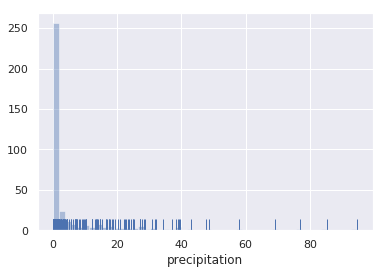

In [51]:
# check distribution of precipitation
x = df1['precipitation']
sns.distplot(x, kde=False, rug=True);

In [0]:
# categorizing precipitation 0-5mm and above 5mm
cat = 5
def preciptation_cat(row):
  if row['precipitation'] < cat:
    return 0
  else:
    return 1

df1['precip_cat'] = df1.apply(preciptation_cat, axis = 1)

# dropping precipitation column
# df1 = df1.drop('precipitation', axis = 1)

In [0]:
# ordering the data so consumption is the last columns (standard practice)
cols = ['day_of_year', 'month', 'day_of_week', 'temp_max', 'precipitation','precip_cat', 'weekend', 'consumption']
df1 = df1[cols]

In [54]:
df1.head()

,day_of_year,month,day_of_week,temp_max,precipitation,precip_cat,weekend,consumption
0,1,1,5,32.5,0.0,0,0,25461
1,2,1,6,33.5,0.0,0,0,28972
2,3,1,7,29.9,0.0,0,1,30814
3,4,1,1,28.6,1.2,0,1,29799
4,5,1,2,28.3,0.0,0,0,28900


In [0]:
# write augmented dataframe to a file


export_csv = df1.to_csv (r'C:\Users\Oded\Google Drive\Naya - Data Science Course\Projects\Project 4 - Beer_Consumption_SaoPaulo\BeerConsumption_Augmented.csv', index = None, header=True)




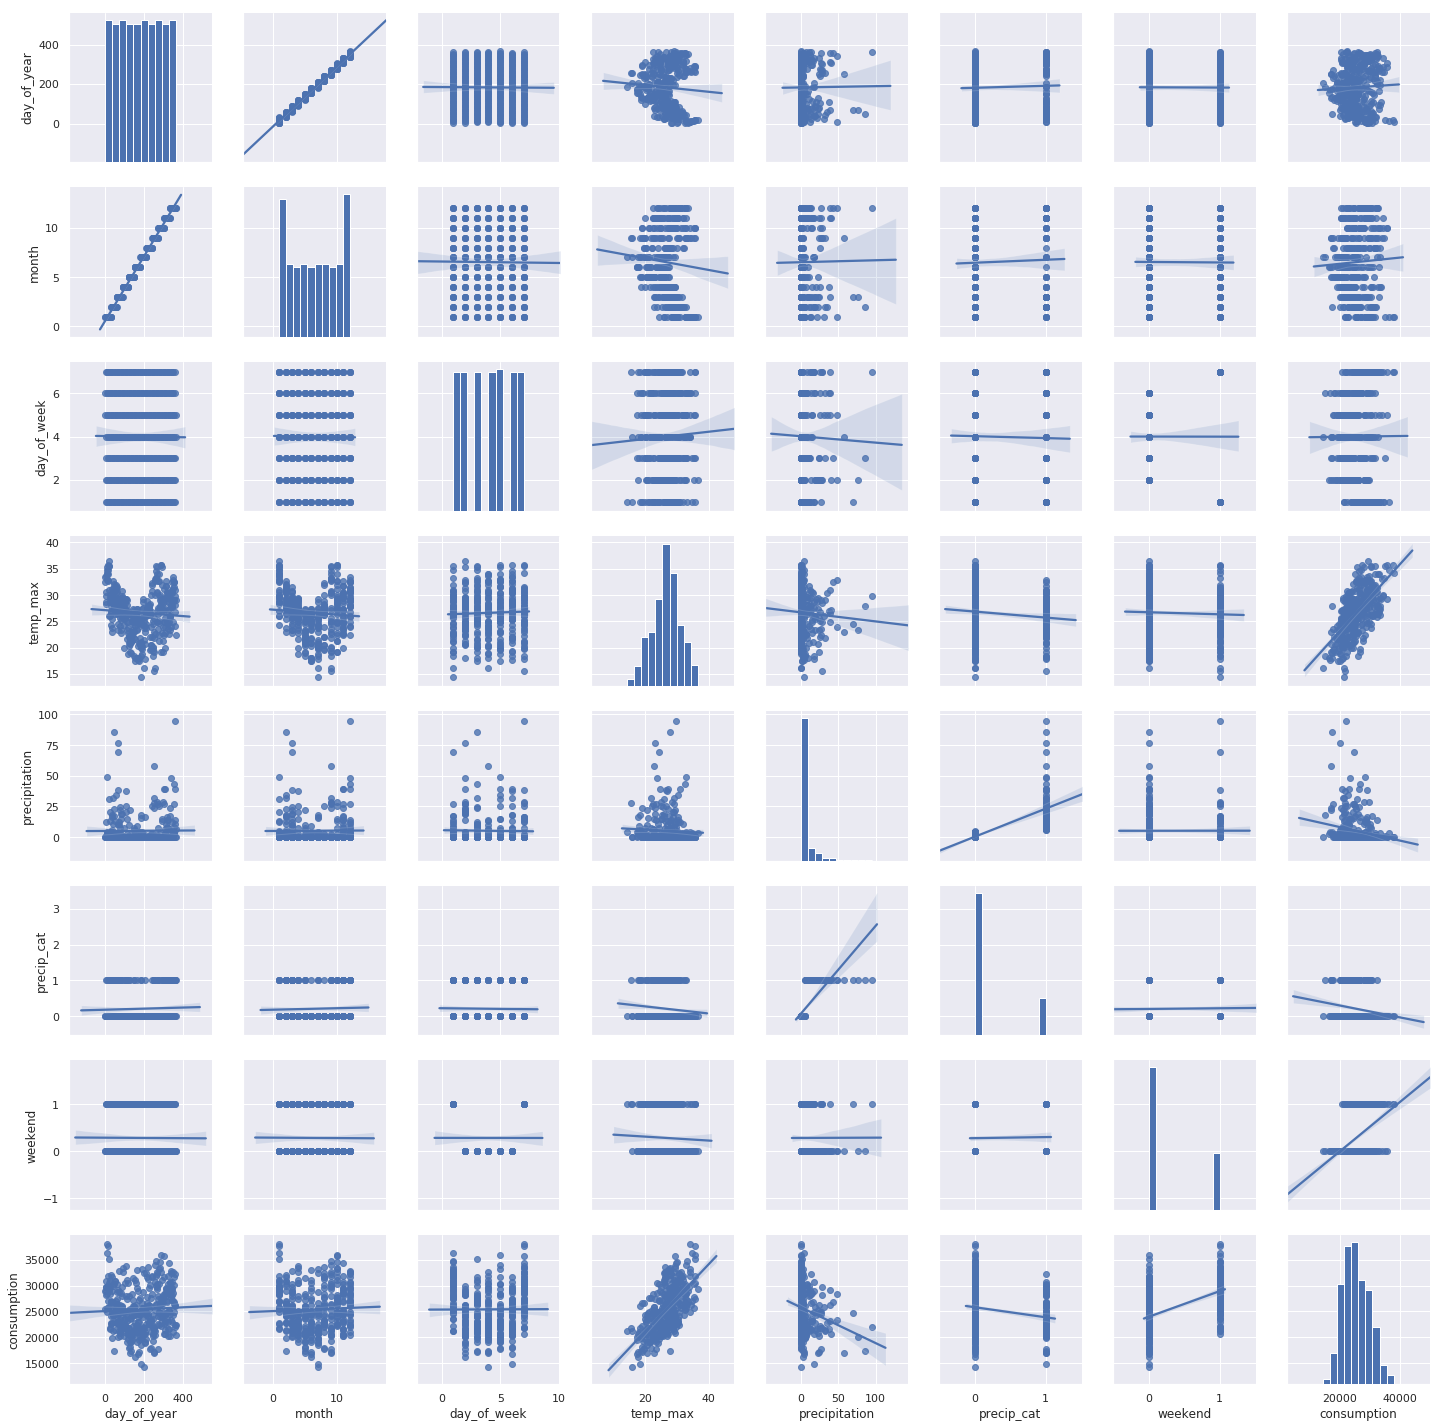

In [56]:
# sns.pairplot(df1, hue = 'weekend', kind = 'reg')       # plot correlations between features of augmented data - differentiator: weekend
sns.pairplot(df1, kind = 'reg')       # plot correlations between features of augmented data - differentiator: weekend

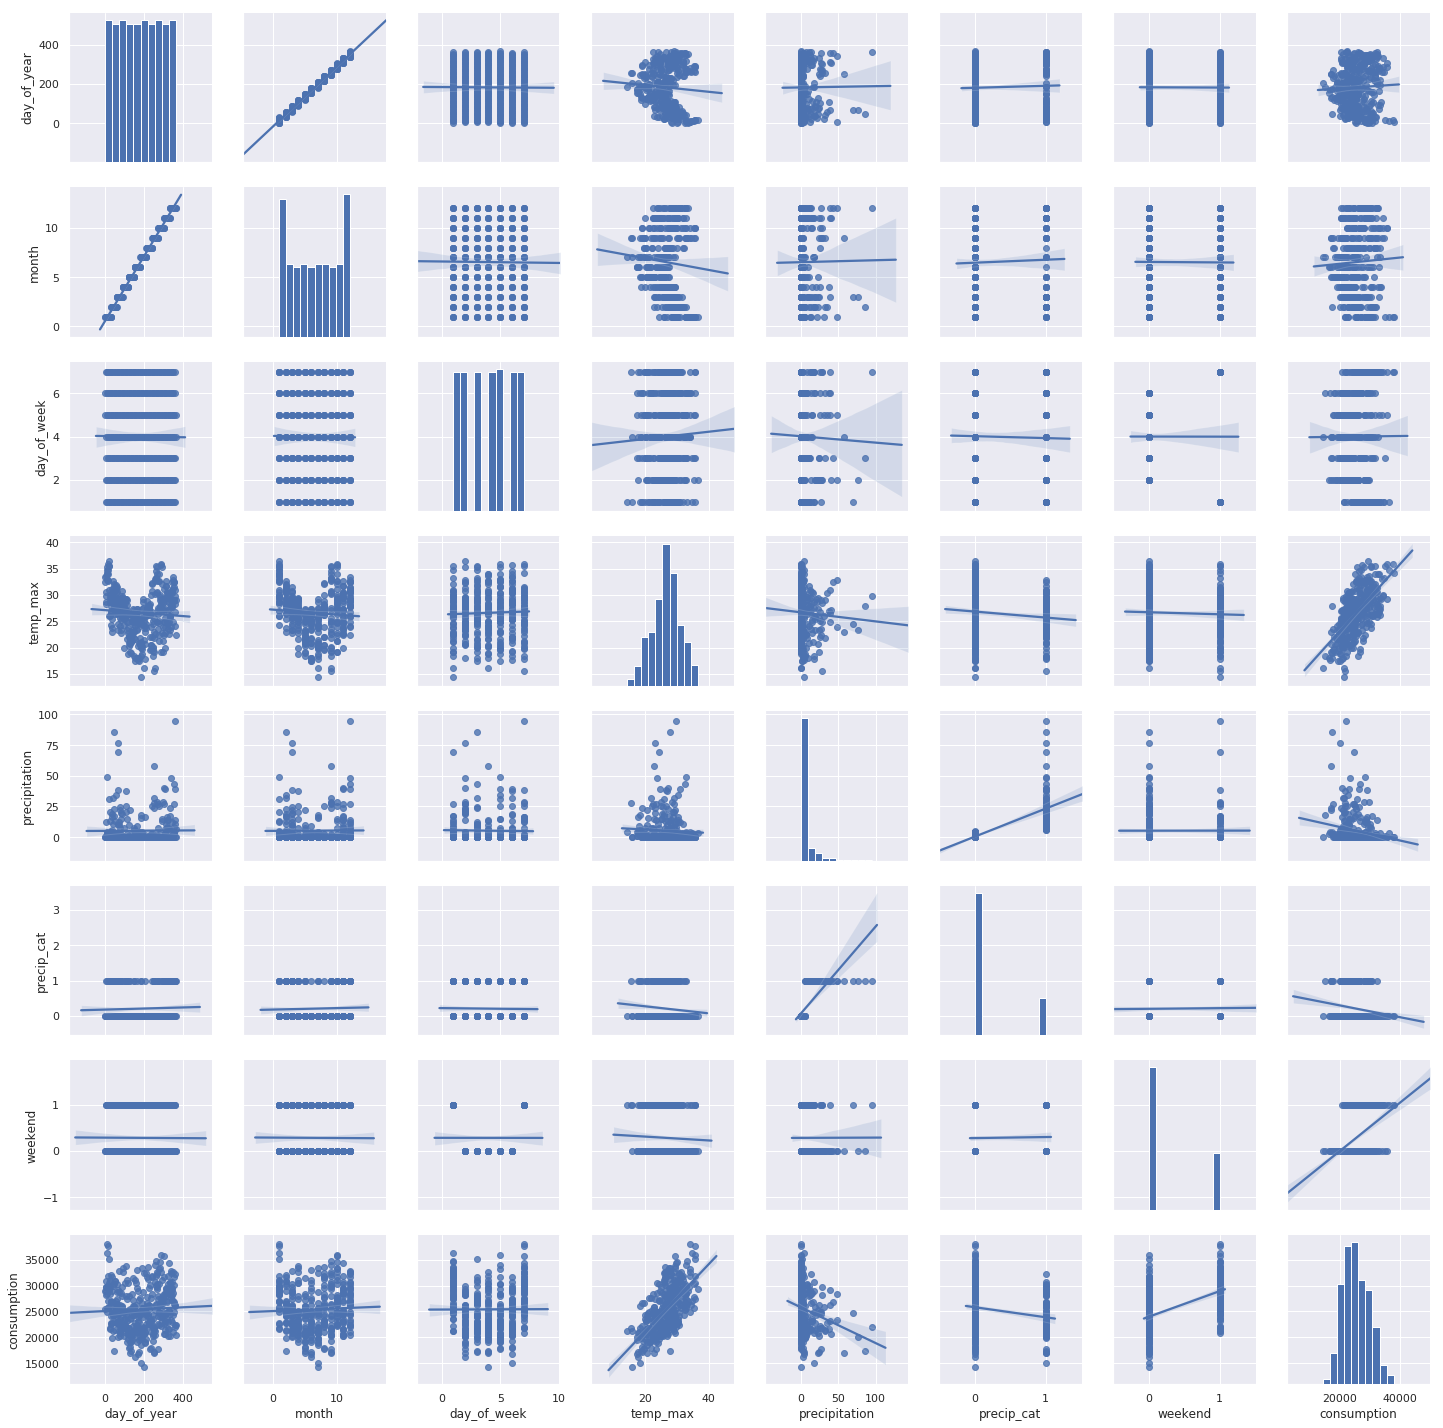

In [0]:
# sns.pairplot(df1, hue = 'precip_cat', kind = 'reg')       # plot correlations between features of augmented data  - differentiator: precipitation category
sns.pairplot(df1, kind = 'reg')       # plot correlations between features of augmented data  - differentiator: precipitation category

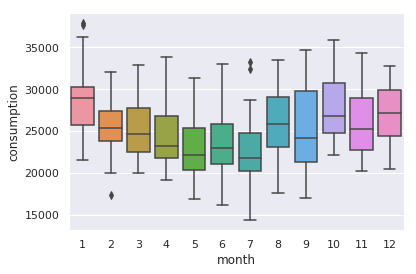

In [57]:
# plotting consumption distribution by month
x = df1['month']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

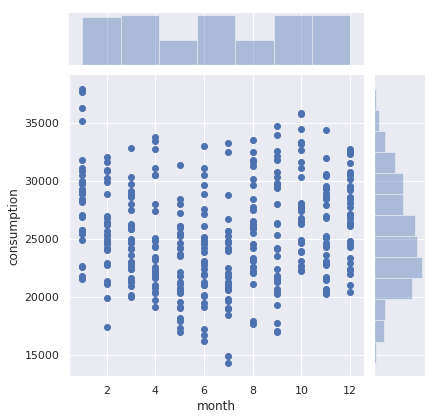

In [58]:
# plotting consumption distribution by month with precipiatin category differentiator
x = df1['month']
y = df1['consumption']
hue = 'weekend'
ax = sns.jointplot(x=x, y=y, data=df1)

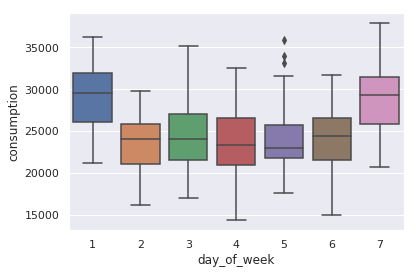

In [59]:
# plotting consumption distribution by day
x = df1['day_of_week']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

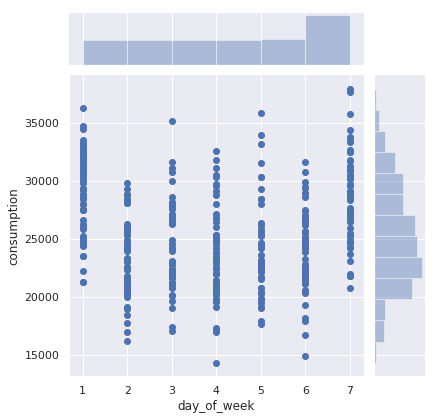

In [60]:
x = df1['day_of_week']
y = df1['consumption']
ax = sns.jointplot(x = x, y = y, data=df1)




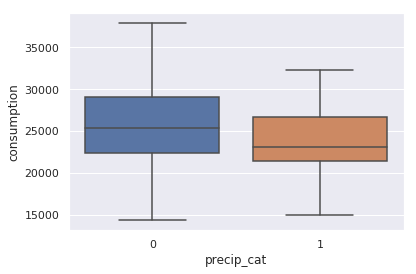

In [61]:
# plotting consumption distribution by precipitation category
x = df1['precip_cat']
y = df1['consumption']
ax = sns.boxplot(x=x, y=y, data=df1)

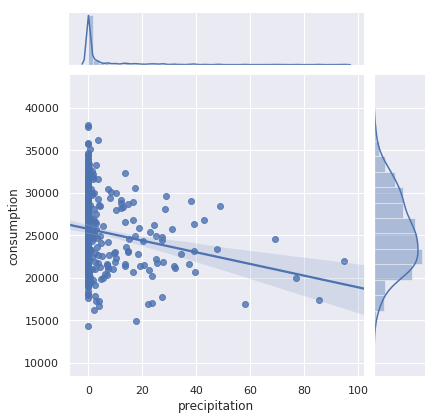

In [62]:
# plotting consumption distribution by precipitatio

cat = 5
x = df1['precipitation']
y = df1['consumption']

g = sns.jointplot(x = x, y = y, data=df1, kind="reg")



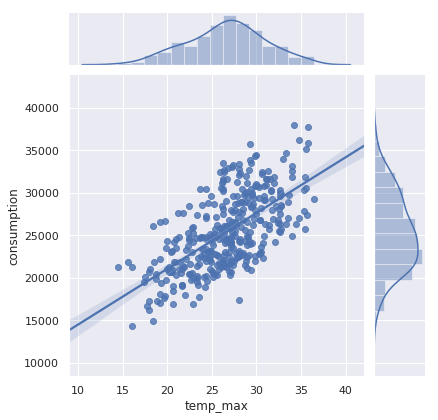

In [63]:
# plotting consumption distribution by maximum temperature
x = df1['temp_max']
y = df1['consumption']
g = sns.jointplot(x = x, y = y, data=df1,kind="reg")

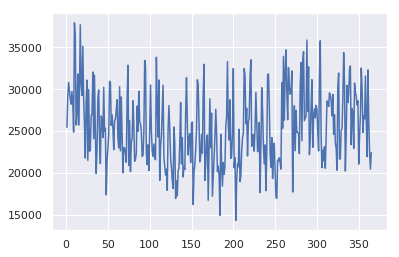

In [64]:
fig = plt.figure()
ax = plt.axes()

weekend = np.nan
# weekend = 1
# weekend = 0
if weekend not in (0,1):
  x = df1['day_of_year']
  y = df1['consumption']

else:
  x = df1.loc[df1['weekend'] == weekend, 'day_of_year']
  y = df1.loc[df1['weekend'] == weekend, 'consumption']
  
ax.plot(x, y);

### **EDA Conclusions**
1. Beer consumption is higher in the summer months. This correlates to beer consumption as temperature increases
2. Beer consumption is higher on the weekends (Saturday, Sunday) than on week days
3. Beer consumption is highest when there is no precipitation (rain falls). When categorizing the days that have and days that do not have precipitation, we see that there is no significant difference
4. Although there is a decreasing trend of consumption as precipitation increases, those that do drink when it rains, tend to consume the same amount of beer. Seeing the same downward trend when there is precipitation on weekends
4. Beer consumption increases as the daily max temperature increases